# 1.复现课程知识库助手搭建过程

####  数据收集
在这个例子中，选择由上海人工智能实验室开源的一系列大模型工具开源仓库作为语料库来源，包括：

 - OpenCompass：面向大模型评测的一站式平台
 - IMDeploy：涵盖了 LLM 任务的全套轻量化、部署和服务解决方案的高效推理工具箱
 - XTuner：轻量级微调大语言模型的工具库
 - InternLM-XComposer：浦语·灵笔，基于书生·浦语大语言模型研发的视觉-语言大模型
 - Lagent：一个轻量级、开源的基于大语言模型的智能体（agent）框架
 - InternLM：一个开源的轻量级训练框架，旨在支持大模型训练而无需大量的依赖
先将上述远程开源仓库Clone到本地，可以使用以下命令：

```python
# 进入到数据库盘
cd /root/data
# clone 上述开源仓库
git clone https://gitee.com/open-compass/opencompass.git
git clone https://gitee.com/InternLM/lmdeploy.git
git clone https://gitee.com/InternLM/xtuner.git
git clone https://gitee.com/InternLM/InternLM-XComposer.git
git clone https://gitee.com/InternLM/lagent.git
git clone https://gitee.com/InternLM/InternLM.git
```
为语料处理方便，我们将选用上述仓库中所有的 markdown、txt 文件作为示例语料库。注意，也可以选用其中的代码文件加入到知识库中，但需要针对代码文件格式进行额外处理（因为代码文件对逻辑联系要求较高，且规范性较强，在分割时最好基于代码模块进行分割再加入向量数据库）。
接下来查找后缀为.md和.txt的文件路径：

```python
import os 
def get_files(dir_path):
    # args：dir_path，目标文件夹路径
    file_list = []
    for filepath, dirnames, filenames in os.walk(dir_path):
        # os.walk 函数将递归遍历指定文件夹
        for filename in filenames:
            # 通过后缀名判断文件类型是否满足要求
            if filename.endswith(".md"):
                # 如果满足要求，将其绝对路径加入到结果列表
                file_list.append(os.path.join(filepath, filename))
            elif filename.endswith(".txt"):
                file_list.append(os.path.join(filepath, filename))
    return file_list
```
####  加载数据
得到所有目标文件路径之后，我们可以使用 LangChain 提供的 FileLoader 对象来加载目标文件，得到由目标文件解析出的纯文本内容。由于不同类型的文件需要对应不同的 FileLoader，我们判断目标文件类型，并针对性调用对应类型的 FileLoader，同时，调用 FileLoader 对象的 load 方法来得到加载之后的纯文本对象：

```python
from tqdm import tqdm
from langchain.document_loaders import UnstructuredFileLoader
from langchain.document_loaders import UnstructuredMarkdownLoader

def get_text(dir_path):
    # args：dir_path，目标文件夹路径
    # 首先调用上文定义的函数得到目标文件路径列表
    file_lst = get_files(dir_path)
    # docs 存放加载之后的纯文本对象
    docs = []
    # 遍历所有目标文件
    for one_file in tqdm(file_lst):
        file_type = one_file.split('.')[-1]
        if file_type == 'md':
            loader = UnstructuredMarkdownLoader(one_file)
        elif file_type == 'txt':
            loader = UnstructuredFileLoader(one_file)
        else:
            # 如果是不符合条件的文件，直接跳过
            continue
        docs.extend(loader.load())
    return docs
```
通过这个函数我们会得到一个纯文本对象对应的列表。
#### 构建向量数据库
得到纯文本对象对应列表之后，我们就可以将它引入到 LangChain 框架中构建向量数据库。由纯文本对象构建向量数据库，我们需要先对文本进行分块，接着对文本块进行向量化。
LangChain 提供了多种文本分块工具，此处我们使用字符串递归分割器，并选择分块大小为 500，块重叠长度为 150。文本分块教程[《LangChain-Chat With Your Data》](https://github.com/datawhalechina/prompt-engineering-for-developers/blob/9dbcb48416eb8af9ff9447388838521dc0f9acb0/content/LangChain%20Chat%20with%20Your%20Data/1.%E7%AE%80%E4%BB%8B%20Introduction.md)

```python
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=150)
split_docs = text_splitter.split_documents(docs)
```
接着我们选用开源词向量模型 Sentence Transformer 来进行文本向量化。LangChain 提供了直接引入 HuggingFace 开源社区中的模型进行向量化的接口：

```python
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="/root/data/model/sentence-transformer")
```
同时，考虑到 Chroma 是目前最常用的入门数据库，我们选择 Chroma 作为向量数据库，基于上文分块后的文档以及加载的开源向量化模型，将语料加载到指定路径下的向量数据库

```python
from langchain.vectorstores import Chroma

# 定义持久化路径
persist_directory = 'data_base/vector_db/chroma'
# 加载数据库
vectordb = Chroma.from_documents(
    documents=split_docs,
    embedding=embeddings,
    persist_directory=persist_directory  # 允许我们将persist_directory目录保存到磁盘上
)
# 将加载的向量数据库持久化到磁盘上
vectordb.persist()
```
运行完上述代码之后，可以在本地构建已持久化的向量数据库。

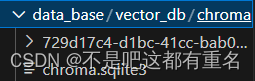

### InternLM接入LangChain
为便捷构建 LLM 应用，我们需要基于本地部署的 InternLM，继承 LangChain 的 LLM 类自定义一个 InternLM LLM 子类，从而实现将 InternLM 接入到 LangChain 框架中。完成 LangChain 的自定义 LLM 子类之后，可以以完全一致的方式调用 LangChain 的接口，而无需考虑底层模型调用的不一致。
基于本地部署的 InternLM 自定义 LLM 类并不复杂，我们只需从 LangChain.llms.base.LLM 类继承一个子类，并重写构造函数与 _call 函数即可：

```python
from langchain.llms.base import LLM
from typing import Any, List, Optional
from langchain.callbacks.manager import CallbackManagerForLLMRun
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

class InternLM_LLM(LLM):
    # 基于本地 InternLM 自定义 LLM 类
    tokenizer : AutoTokenizer = None
    model: AutoModelForCausalLM = None

    def __init__(self, model_path :str):
        # model_path: InternLM 模型路径
        # 从本地初始化模型
        super().__init__()
        print("正在从本地加载模型...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
        self.model = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True).to(torch.bfloat16).cuda()
        self.model = self.model.eval()
        print("完成本地模型的加载")

    def _call(self, prompt : str, stop: Optional[List[str]] = None,
                run_manager: Optional[CallbackManagerForLLMRun] = None,
                **kwargs: Any):
        # 重写调用函数
        system_prompt = """You are an AI assistant whose name is InternLM (书生·浦语).
        - InternLM (书生·浦语) is a conversational language model that is developed by Shanghai AI Laboratory (上海人工智能实验室). It is designed to be helpful, honest, and harmless.
        - InternLM (书生·浦语) can understand and communicate fluently in the language chosen by the user such as English and 中文.
        """
        
        messages = [(system_prompt, '')]
        response, history = self.model.chat(self.tokenizer, prompt , history=messages)
        return response
        
    @property
    def _llm_type(self) -> str:
        return "InternLM"
```
在上述类定义中，我们分别重写了构造函数和 _call 函数：对于构造函数，我们在对象实例化的一开始加载本地部署的 InternLM 模型，从而避免每一次调用都需要重新加载模型带来的时间过长；_call 函数是 LLM 类的核心函数，LangChain 会调用该函数来调用 LLM，在该函数中，我们调用已实例化模型的 chat 方法，从而实现对模型的调用并返回调用结果。
在整体项目中，我们将上述代码封装为 LLM.py，后续将直接从该文件中引入自定义的 LLM 类。
### 构建检索问答链
LangChain 通过提供检索问答链对象来实现对于 RAG 全流程的封装。所谓检索问答链，即通过一个对象完成检索增强问答（即RAG）的全流程，针对 RAG 的更多概念，我们会在视频内容中讲解，也欢迎读者查阅该教程来进一步了解：[《LLM Universe》](https://github.com/datawhalechina/llm-universe/tree/main)。我们可以调用一个 LangChain 提供的 RetrievalQA 对象，通过初始化时填入已构建的数据库和自定义 LLM 作为参数，来简便地完成检索增强问答的全流程，LangChain 会自动完成基于用户提问进行检索、获取相关文档、拼接为合适的 Prompt 并交给 LLM 问答的全部流程。
####  加载向量数据库
首先我们需要将上文构建的向量数据库导入进来，我们可以直接通过 Chroma 以及上文定义的词向量模型来加载已构建的数据库：

```python
from langchain.vectorstores import Chroma
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
import os

# 定义 Embeddings
embeddings = HuggingFaceEmbeddings(model_name="/root/data/model/sentence-transformer")

# 向量数据库持久化路径
persist_directory = 'data_base/vector_db/chroma'

# 加载数据库
vectordb = Chroma(
    persist_directory=persist_directory, 
    embedding_function=embeddings
)
```
上述代码得到的 vectordb 对象即为我们已构建的向量数据库对象，该对象可以针对用户的 query 进行语义向量检索，得到与用户提问相关的知识片段。
#### 实例化自定义LLM与Prompt Template
接着，我们实例化一个基于 InternLM 自定义的 LLM 对象：

```python
from LLM import InternLM_LLM
llm = InternLM_LLM(model_path = "/root/data/model/Shanghai_AI_Laboratory/internlm-chat-7b")
llm.predict("你是谁")
```
构建检索问答链，还需要构建一个 Prompt Template，该 Template 其实基于一个带变量的字符串，在检索之后，LangChain 会将检索到的相关文档片段填入到 Template 的变量中，从而实现带知识的 Prompt 构建。我们可以基于 LangChain 的 Template 基类来实例化这样一个 Template 对象：

```python
from langchain.prompts import PromptTemplate

# 我们所构造的 Prompt 模板
template = """使用以下上下文来回答用户的问题。如果你不知道答案，就说你不知道。总是使用中文回答。
问题: {question}
可参考的上下文：
···
{context}
···
如果给定的上下文无法让你做出回答，请回答你不知道。
有用的回答:"""

# 调用 LangChain 的方法来实例化一个 Template 对象，该对象包含了 context 和 question 两个变量，在实际调用时，这两个变量会被检索到的文档片段和用户提问填充
QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context","question"],template=template)
```
####  构建检索问答链
最后，可以调用 LangChain 提供的检索问答链构造函数，基于我们的自定义 LLM、Prompt Template 和向量知识库来构建一个基于 InternLM 的检索问答链：

```python
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(llm,retriever=vectordb.as_retriever(),return_source_documents=True,chain_type_kwargs={"prompt":QA_CHAIN_PROMPT})
```
得到的 qa_chain 对象即可以实现我们的核心功能，即基于 InternLM 模型的专业知识库助手。我们可以对比该检索问答链和纯 LLM 的问答效果：

```python
# 检索问答链回答效果
question = "什么是InternLM"
result = qa_chain({"query": question})
print("检索问答链回答 question 的结果：")
print(result["result"])

# 仅 LLM 回答效果
result_2 = llm(question)
print("大模型回答 question 的结果：")
print(result_2)
```
下面是运行上述代码后的结果：


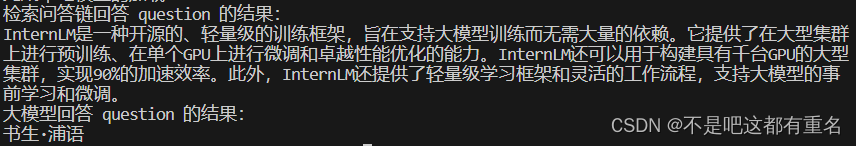

###  部署Web Demo
在完成上述核心功能后，我们可以基于 Gradio 框架将其部署到 Web 网页，从而搭建一个小型 Demo，便于测试与使用。
我们首先将上文的代码内容封装为一个返回构建的检索问答链对象的函数，并在启动 Gradio 的第一时间调用该函数得到检索问答链对象，后续直接使用该对象进行问答对话，从而避免重复加载模型：

```python

from langchain.vectorstores import Chroma
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
import os
from LLM import InternLM_LLM
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA

def load_chain():
    # 加载问答链
    # 定义 Embeddings
    embeddings = HuggingFaceEmbeddings(model_name="/root/data/model/sentence-transformer")

    # 向量数据库持久化路径
    persist_directory = 'data_base/vector_db/chroma'

    # 加载数据库
    vectordb = Chroma(
        persist_directory=persist_directory,  # 允许我们将persist_directory目录保存到磁盘上
        embedding_function=embeddings
    )

    # 加载自定义 LLM
    llm = InternLM_LLM(model_path = "/root/data/model/Shanghai_AI_Laboratory/internlm-chat-7b")

    # 定义一个 Prompt Template
    template = """使用以下上下文来回答最后的问题。如果你不知道答案，就说你不知道，不要试图编造答
    案。尽量使答案简明扼要。总是在回答的最后说“谢谢你的提问！”。
    {context}
    问题: {question}
    有用的回答:"""

    QA_CHAIN_PROMPT = PromptTemplate(input_variables=["context","question"],template=template)

    # 运行 chain
    qa_chain = RetrievalQA.from_chain_type(llm,retriever=vectordb.as_retriever(),return_source_documents=True,chain_type_kwargs={"prompt":QA_CHAIN_PROMPT})
    
    return qa_chain
```
接着我们定义一个类，该类负责加载并存储检索问答链，并响应 Web 界面里调用检索问答链进行回答的动作：

```python
class Model_center():
    """
    存储检索问答链的对象 
    """
    def __init__(self):
        # 构造函数，加载检索问答链
        self.chain = load_chain()

    def qa_chain_self_answer(self, question: str, chat_history: list = []):
        """
        调用问答链进行回答
        """
        if question == None or len(question) < 1:
            return "", chat_history
        try:
            chat_history.append(
                (question, self.chain({"query": question})["result"]))
            # 将问答结果直接附加到问答历史中，Gradio 会将其展示出来
            return "", chat_history
        except Exception as e:
            return e, chat_history
```
接着我们定义一个类，该类负责加载并存储检索问答链，并响应 Web 界面里调用检索问答链进行回答的动作：

```python
class Model_center():
    """
    存储检索问答链的对象 
    """
    def __init__(self):
        # 构造函数，加载检索问答链
        self.chain = load_chain()

    def qa_chain_self_answer(self, question: str, chat_history: list = []):
        """
        调用问答链进行回答
        """
        if question == None or len(question) < 1:
            return "", chat_history
        try:
            chat_history.append(
                (question, self.chain({"query": question})["result"]))
            # 将问答结果直接附加到问答历史中，Gradio 会将其展示出来
            return "", chat_history
        except Exception as e:
            return e, chat_history

```
然后我们只需按照 Gradio 的框架使用方法，实例化一个 Web 界面并将点击动作绑定到上述类的回答方法即可：

```python
import gradio as gr

# 实例化核心功能对象
model_center = Model_center()
# 创建一个 Web 界面
block = gr.Blocks()
with block as demo:
    with gr.Row(equal_height=True):   
        with gr.Column(scale=15):
            # 展示的页面标题
            gr.Markdown("""<h1><center>InternLM</center></h1>
                <center>书生浦语</center>
                """)

    with gr.Row():
        with gr.Column(scale=4):
            # 创建一个聊天机器人对象
            chatbot = gr.Chatbot(height=450, show_copy_button=True)
            # 创建一个文本框组件，用于输入 prompt。
            msg = gr.Textbox(label="Prompt/问题")

            with gr.Row():
                # 创建提交按钮。
                db_wo_his_btn = gr.Button("Chat")
            with gr.Row():
                # 创建一个清除按钮，用于清除聊天机器人组件的内容。
                clear = gr.ClearButton(
                    components=[chatbot], value="Clear console")
                
        # 设置按钮的点击事件。当点击时，调用上面定义的 qa_chain_self_answer 函数，并传入用户的消息和聊天历史记录，然后更新文本框和聊天机器人组件。
        db_wo_his_btn.click(model_center.qa_chain_self_answer, inputs=[
                            msg, chatbot], outputs=[msg, chatbot])

    gr.Markdown("""提醒：<br>
    1. 初始化数据库时间可能较长，请耐心等待。
    2. 使用中如果出现异常，将会在文本输入框进行展示，请不要惊慌。 <br>
    """)
gr.close_all()
# 直接启动
demo.launch()
```
通过将上述代码封装为 run_gradio.py 脚本，直接通过 python 命令运行，即可在本地启动知识库助手的 Web Demo，默认会在 7860 端口运行，接下来将服务器端口映射到本地端口即可访问，下面是实现效果：

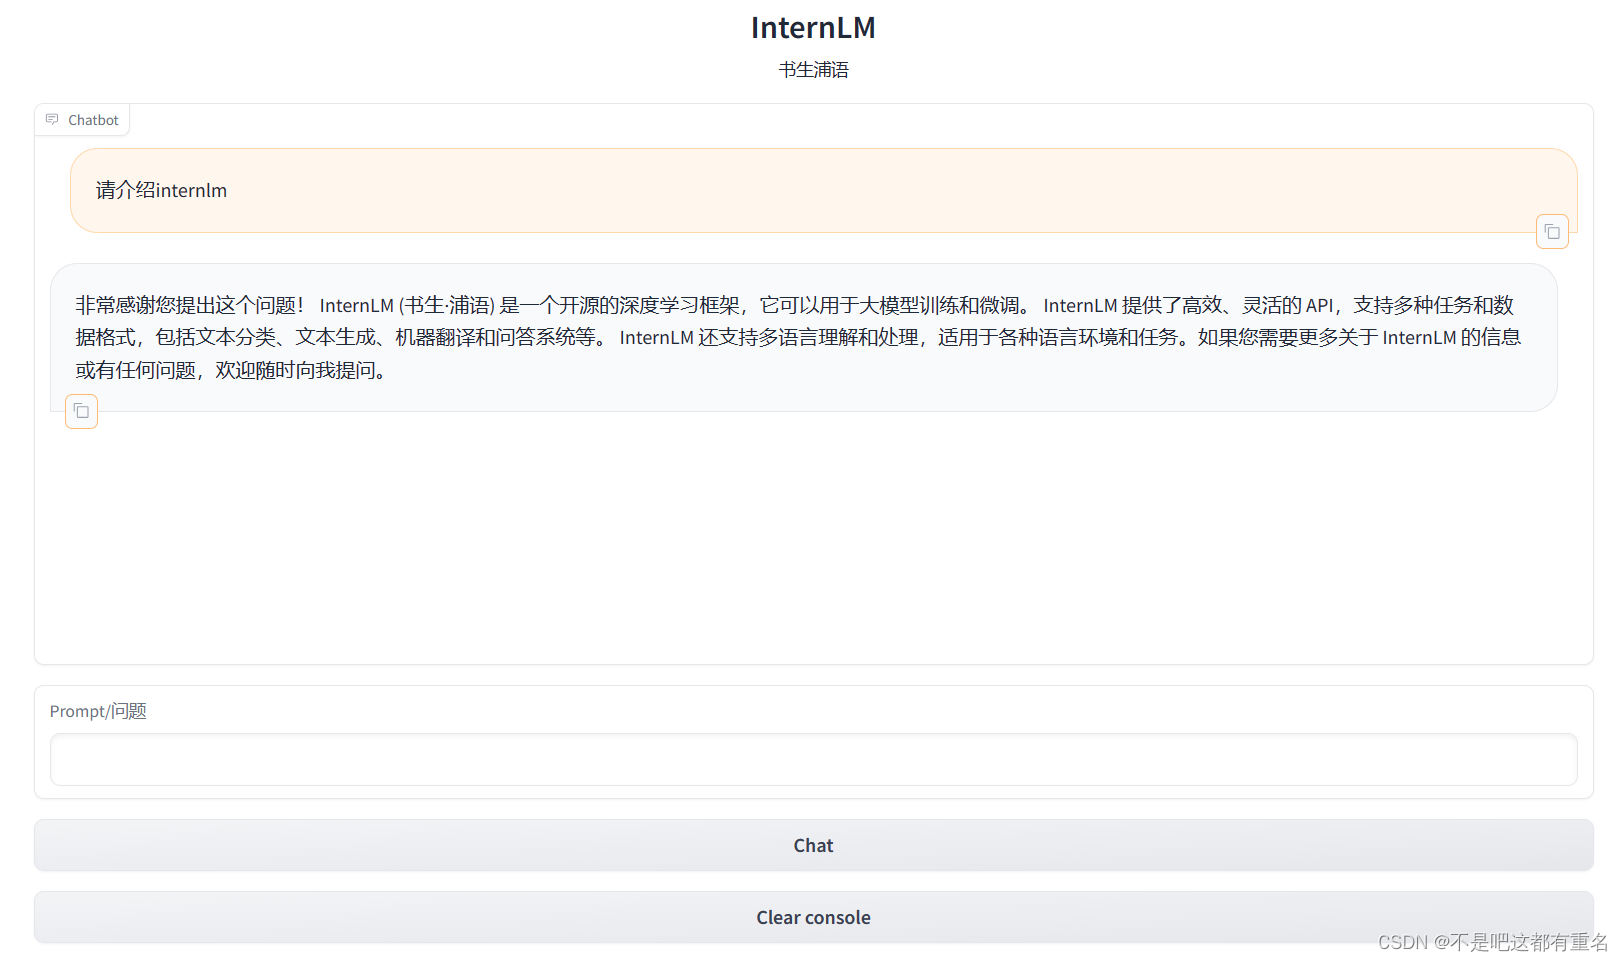

# 2.畜禽领域的专业问答助手，并在 OpenXLab 上成功部署

# 1.目标是建立一个关于牛的跛行的专业问答助手
第一步构建自己的数据库，因为论文是pdf格式，所以使用langchain提供的PyPDFLoader加载数据

from langchain.document_loaders import PyPDFLoader

然后复用教程中提供的代码，略微修改pdf文件加载的方式，生成牛跛行的向量数据库

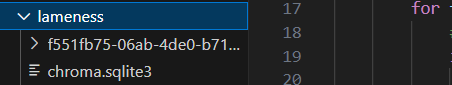

然后同样复用webdemo的代码，修改向量数据库的路径，就可以运行，实际运行效果如下

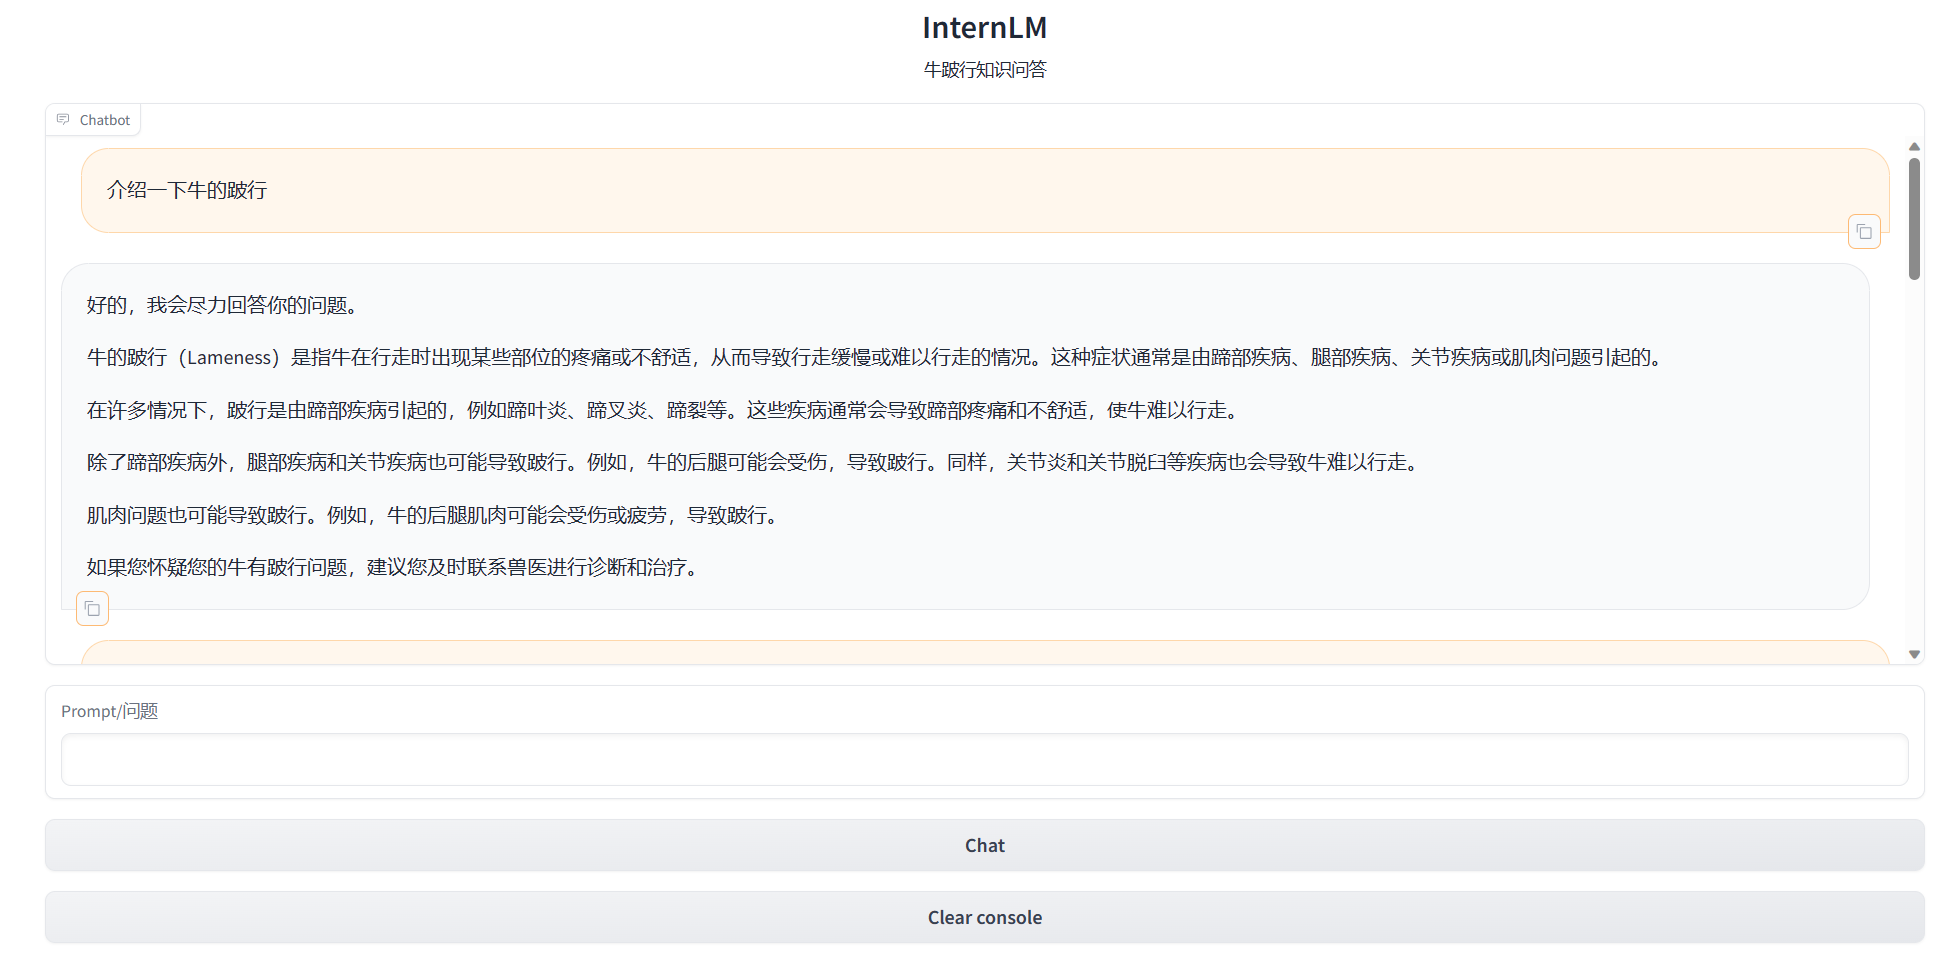

# 2.在OpenXLab上的部署

1.重新组织文件目录，如下所示

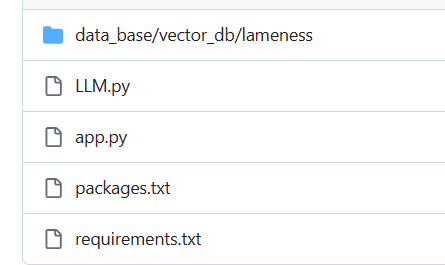

其中requirements.txt中包含所有的依赖包

2.然后修改app.py中的模型的读取，按照Openxlab中的教程，将internlm-chat-7b和sentence-transformer模型改为在线下载

In [ ]:
from openxlab.model import download
download(model_repo='OpenLMLab/InternLM-chat-7b',output='./internlm-chat-7b')

In [ ]:
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
# 下载模型
os.system('huggingface-cli download --resume-download sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 --local-dir ./sentence-transformer')

同时在部署过程中会报错，提示Splite3的版本过低，因此在pip install pysqlite3-binary后用如下代码将默认的sqlite3覆盖

In [ ]:
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')

然后只需要修改模型的路径就可以了，最后将该文件目录上传到github，因为部署的时候是直接从github的仓库中读取的

3.部署

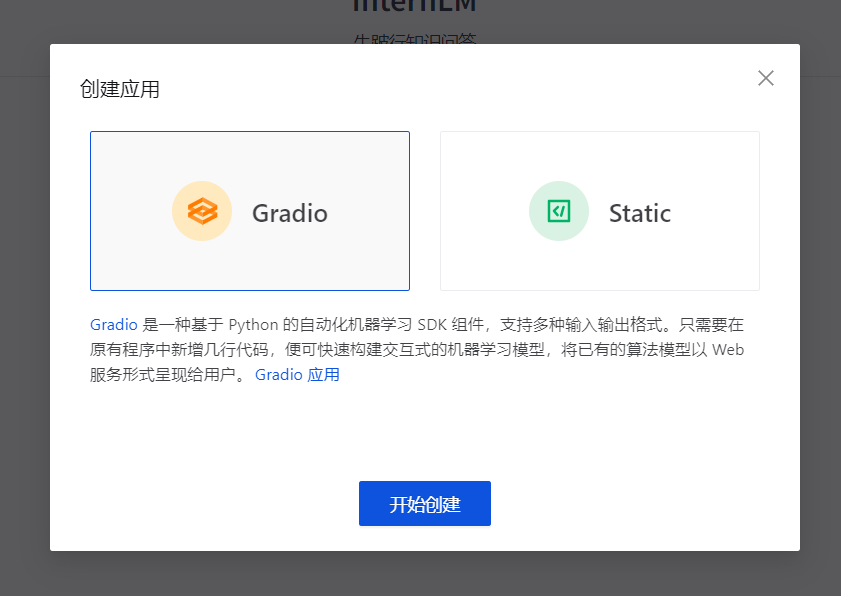

注意要申请带gpu的硬件资源，我这里申请了下面红框中的这个，答复速度还是很快的，感谢工作人员！

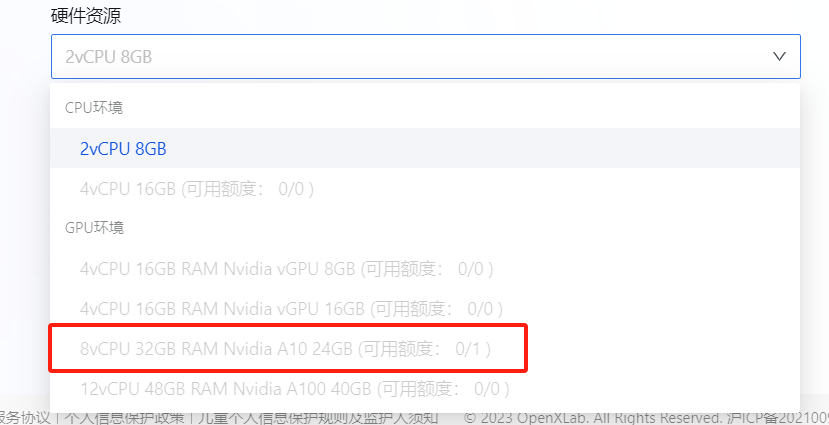

然后按照教程填写部署即可

4.部署后的效果和部署链接

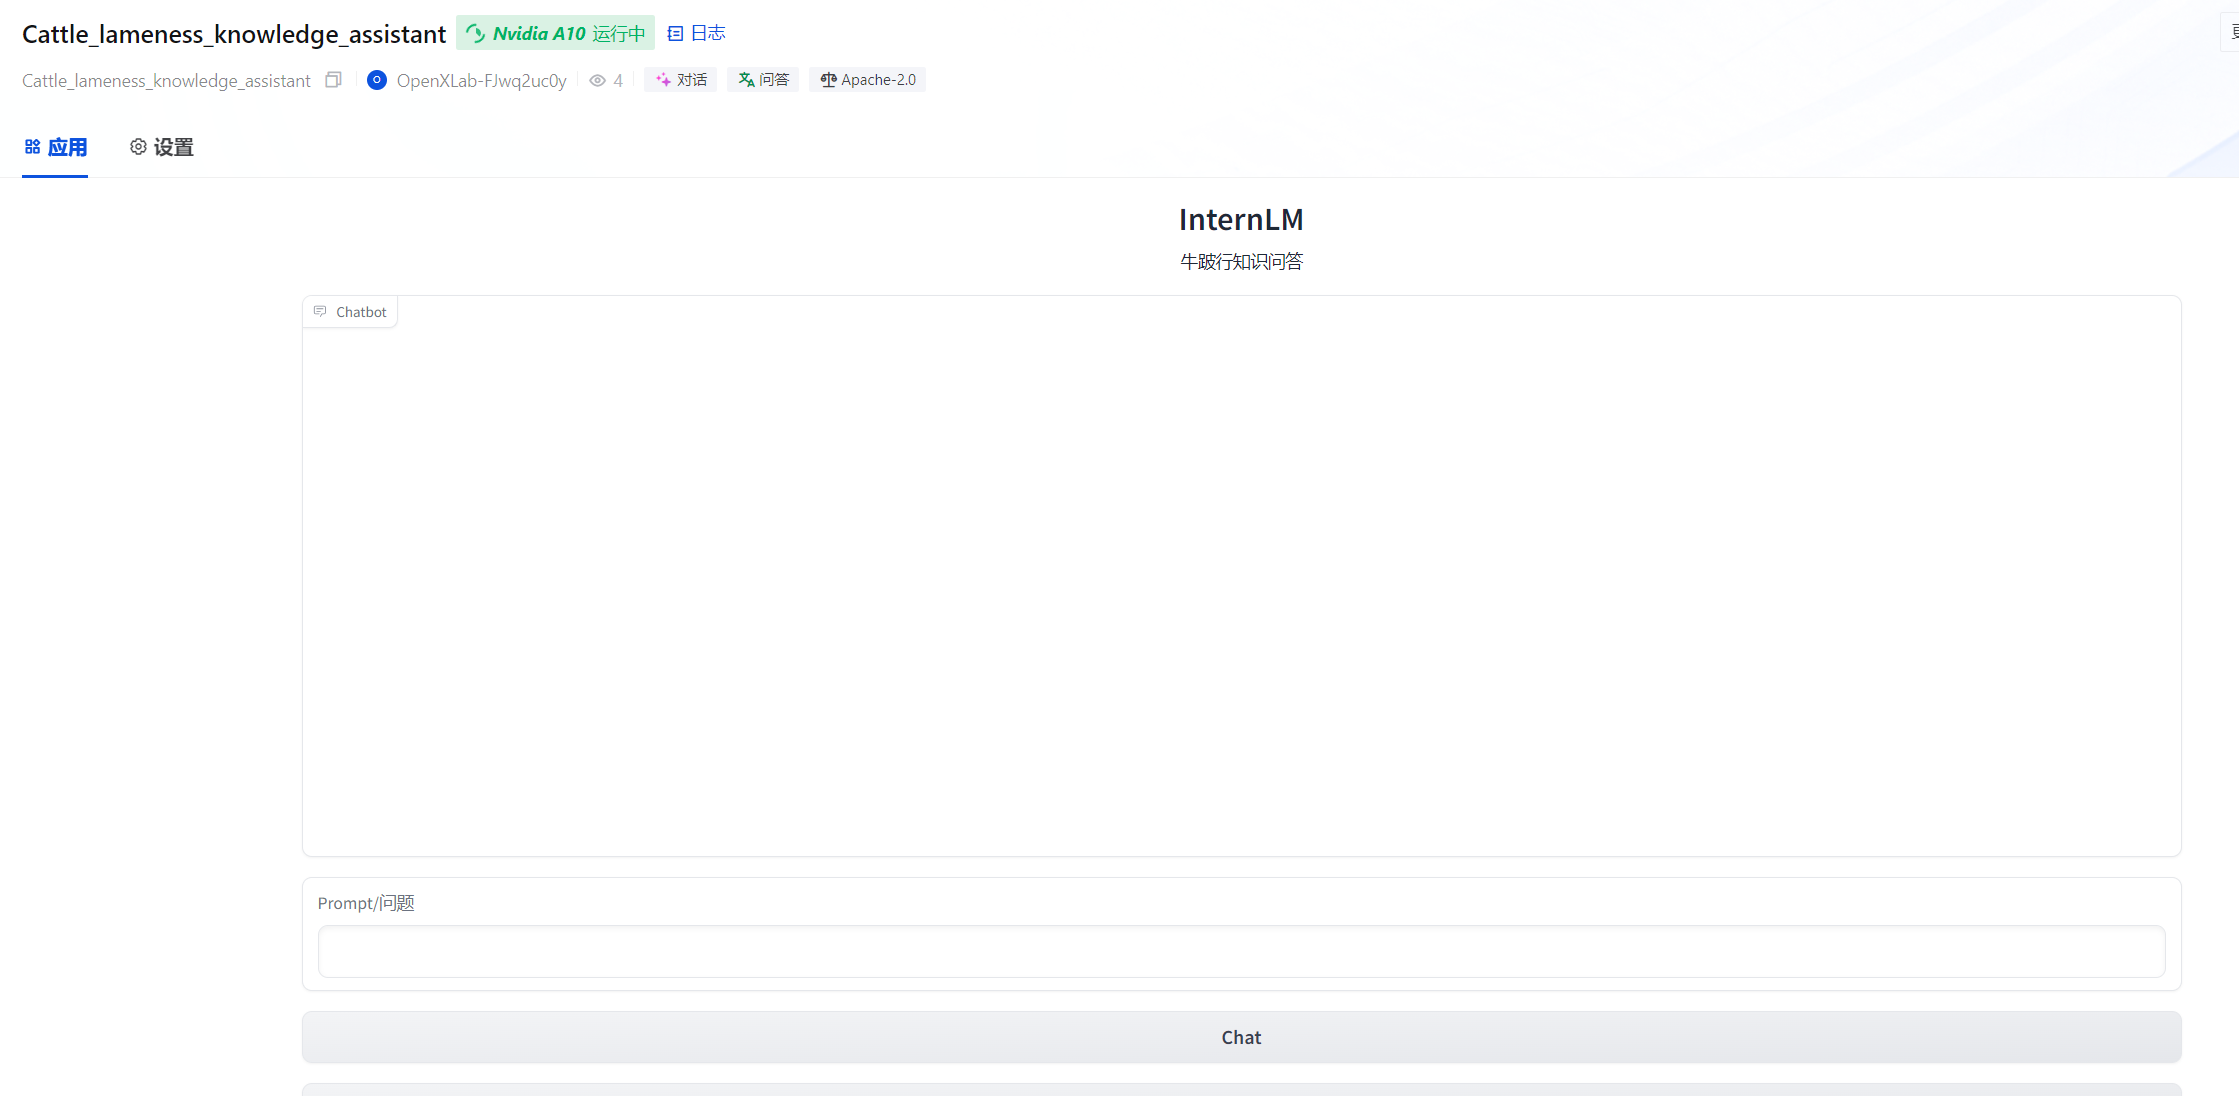

部署链接：https://openxlab.org.cn/apps/detail/Xpg12138/Cattle_lameness_knowledge_assistant

欢迎使用，但是实际效果不太行，可能是数据量太少了，基本只能问问“牛跛行是什么”这一个问题，后面再重新收集整理数据优化一下效果吧，这次作为一个跑通流程的过程，还是学到不少的